In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_0 (1).csv
/kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_2 (1).csv
/kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_1 (1).csv


Loading dataset from /kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_0 (1).csv...
Loading dataset from /kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_1 (1).csv...
Loading dataset from /kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_2 (1).csv...
Datasets loaded and preprocessed.
Communication Round 1/10
  Training model for Client 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training model for Client 2...
  Training model for Client 3...
Communication Round 2/10
  Training model for Client 1...
  Training model for Client 2...
  Training model for Client 3...
Communication Round 3/10
  Training model for Client 1...
  Training model for Client 2...
  Training model for Client 3...
Communication Round 4/10
  Training model for Client 1...
  Training model for Client 2...
  Training model for Client 3...
Communication Round 5/10
  Training model for Client 1...
  Training model for Client 2...
  Training model for Client 3...
Communication Round 6/10
  Training model for Client 1...
  Training model for Client 2...
  Training model for Client 3...
Communication Round 7/10
  Training model for Client 1...
  Training model for Client 2...
  Training model for Client 3...
Communication Round 8/10
  Training model for Client 1...
  Training model for Client 2...
  Training model for Client 3...
Communication Round 9/10
  Training model for Client 1...
  Traini

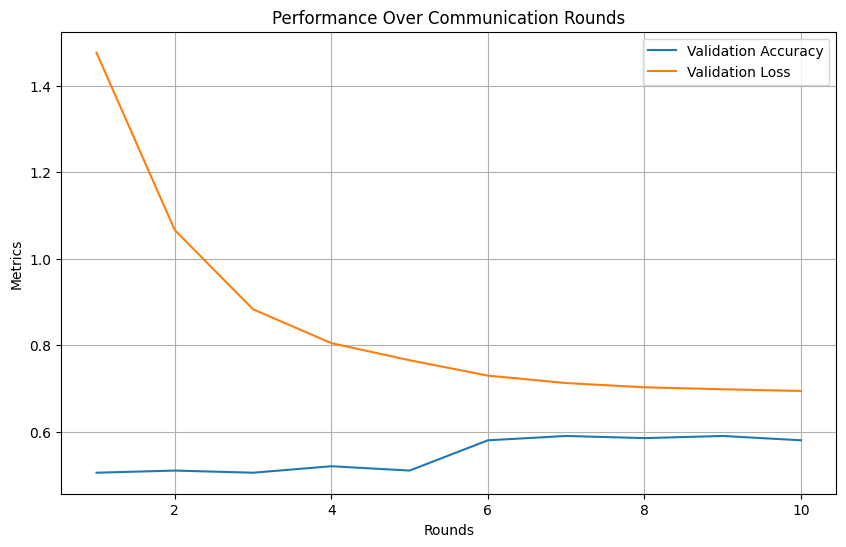

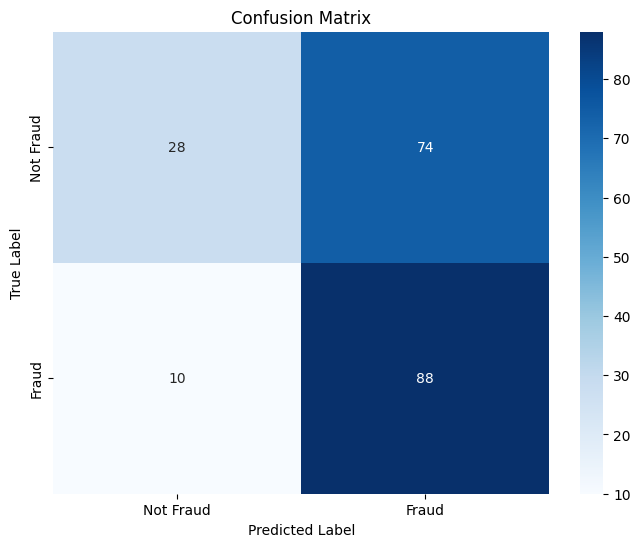

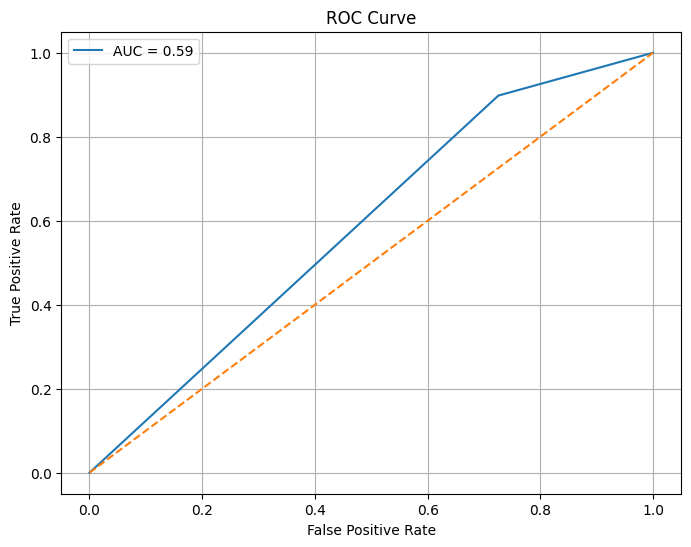

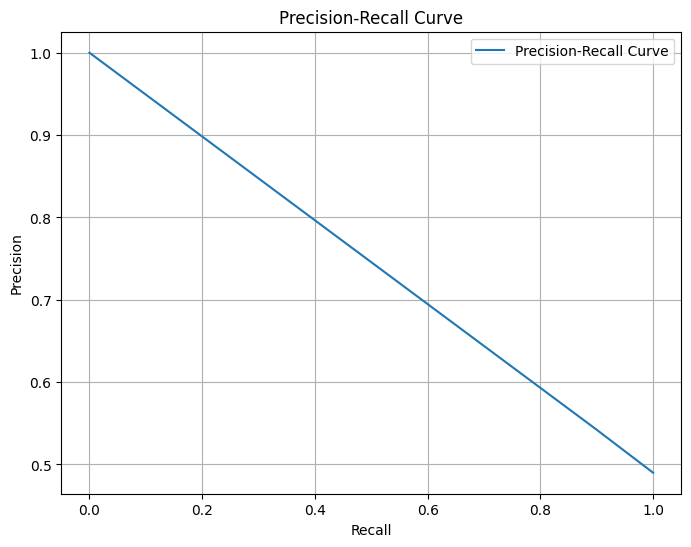

In [7]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import sigmoid
import openpyxl

# Custom Activation Function: Adaptive Swish-ReLU
class AdaptiveSwishReLU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdaptiveSwishReLU, self).__init__(**kwargs)
        self.alpha = tf.Variable(initial_value=0.5, trainable=True, dtype=tf.float32, name="alpha")

    def call(self, inputs):
        return self.alpha * (inputs * tf.nn.sigmoid(inputs)) + (1 - self.alpha) * tf.nn.relu(inputs)


tf.keras.utils.get_custom_objects().update({'AdaptiveSwishReLU': tf.keras.layers.Activation(AdaptiveSwishReLU)})

# Paths to the three datasets (Update these paths for Colab/Kaggle)
dataset_paths = [
    "/kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_0 (1).csv",
    "/kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_1 (1).csv",
    "/kaggle/input/preprocessed-ieee-dataset/preprocessed_bank_2 (1).csv"
]

num_clients = len(dataset_paths)
client_data = []
client_labels = []

for path in dataset_paths:
    print(f"Loading dataset from {path}...")
    df = pd.read_csv(path, low_memory=False)
    df = df.sample(n=200, random_state=42)

    if 'isFraud' not in df.columns:
        raise ValueError("The dataset must have an 'isFraud' column.")

    encoder = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        if col != 'isFraud':
            df[col] = encoder.fit_transform(df[col].astype(str))

    df.fillna(0, inplace=True)
    y = pd.get_dummies(df['isFraud']).to_numpy()
    scaler = MinMaxScaler()
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    X = df.drop(['isFraud'], axis=1)
    client_data.append(X.to_numpy().astype(np.float32))
    client_labels.append(y.astype(np.float32))

print("Datasets loaded and preprocessed.")

def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, input_dim=input_dim, kernel_regularizer=l2(0.01)),
        AdaptiveSwishReLU(),
        Dropout(0.2),
        Dense(32, kernel_regularizer=l2(0.01)),
        AdaptiveSwishReLU(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Aggregation functions
def weight_scaling_factor(client_data, client_idx):
    global_data_count = sum([len(data) for data in client_data])
    local_data_count = len(client_data[client_idx])
    return local_data_count / global_data_count

def scale_model_weights(weights, scalar):
    return [scalar * weight for weight in weights]

def sum_scaled_weights(scaled_weights_list):
    return [np.sum(layer_weights, axis=0) for layer_weights in zip(*scaled_weights_list)]

num_comm_rounds = 10
global_model = create_model(client_data[0].shape[1], client_labels[0].shape[1])
rounds, val_accuracies, val_losses = [], [], []
num_epochs_per_round = 5

for round_num in range(num_comm_rounds):
    print(f"Communication Round {round_num + 1}/{num_comm_rounds}")
    scaled_local_weight_list = []
    for client_idx in range(num_clients):
        print(f"  Training model for Client {client_idx + 1}...")
        local_model = create_model(client_data[client_idx].shape[1], client_labels[client_idx].shape[1])
        local_model.set_weights(global_model.get_weights())
        local_model.fit(client_data[client_idx], client_labels[client_idx], epochs=num_epochs_per_round, batch_size=32, verbose=0)
        scaling_factor = weight_scaling_factor(client_data, client_idx)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    val_loss, val_accuracy = global_model.evaluate(client_data[0], client_labels[0], verbose=0)
    rounds.append(round_num + 1)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

# Generate Predictions and Metrics
true_labels = np.argmax(client_labels[0], axis=1)
predictions = np.argmax(global_model.predict(client_data[0]), axis=1)
conf_matrix = confusion_matrix(true_labels, predictions)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Save results
results = pd.DataFrame({"Round": rounds, "Validation Accuracy": val_accuracies, "Validation Loss": val_losses})
results.to_excel("Results.xlsx", index=False)

# Plot Performance Metrics
plt.figure(figsize=(10, 6))
plt.plot(rounds, val_accuracies, label="Validation Accuracy")
plt.plot(rounds, val_losses, label="Validation Loss")
plt.title("Performance Over Communication Rounds")
plt.xlabel("Rounds")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()